In today's notes, we are going to focus on the following: 

1. Strassen's Matrix Multiplication algorithm. 
2. Optimizing the implementation of the algorithm in Julia. 
3. Paralellizing the algorithm in Julia while keeping the efficiecy. 
4. Benchmark and show that the algorithm is indeed having a complexity less than $O(N^3)$, assuming the matrices are $N \times N$. 

---
### Strassen's Matrix Multiplication Algorithm

The objective of the algorithm is to compute the product of 2 matrices: $A$, $B$. The algorithm uses an recursive approach, here we consider the recursive structure of the matrix in the following ways: 

$$
A = \begin{bmatrix}
A_{1, 1} & A_{1, 2} \\
A_{2, 1} & A_{2, 2} 
\end{bmatrix}
\quad 
B = \begin{bmatrix}
B_{1, 1} & B_{1, 2}\\
B_{2, 1} & B_{2, 2}
\end{bmatrix}
\quad 
C = \begin{bmatrix}
C_{1, 1} & C_{1, 2}\\
C_{2, 1} & C_{2, 2}
\end{bmatrix}
$$

And then, we use these submatrices to compute some intermediate matrices:
$$M_1 = (A_{1, 1}+ A_{2,2})(B_{1, 1} + B_{2,2})$$
$$M_2 = (A_{2, 1} + A_{2,2})B_{1,1}$$
$$M_3 = A_{1,1}(B_{1,2} - B_{2,2})$$
$$M_4 = A_{2,2}(B_{2,1} - B_{1,1})$$
$$M_5 = (A_{1,1} + A_{1,2})B_{2,2}$$
$$M_6 = (A_{2,1} - A_{1,1})(B_{1,1} + B_{1,2})$$
$$M_7 = (A_{1,2} - A_{2,2})(B_{2,1} + B_{2,2})$$

Using these 7 intermediate matrices which are computed using only 7 multiplications, we will get sub-matrices for the $C$ matrix:

$$
C_{1, 1} = M_1 + M_4 - M_5 + M_7
$$
$$
C_{1, 2} = M_3 + M_5
$$
$$
C_{2, 1} = M_2 + M_4
$$
$$
C_{2,2} = M_1 - M_2 + M_3 + M_6
$$





### Extra Rows or Columns that cannot be partitioned
The matrices need to be equally partitioned, meaning that they have size equals to $2^N$. Is it possible to bypass this? 

#### Considering Remainder of Partitioning
Let $A$ be $m\times n$ and $B$ be $n \times k$. Consider the case where $m, n, k$ are all not divisible by 2, then after partitioning the submatrices, we take the last row and column of the matrices as the remainding rows/columns. Then the matrices can be structurally represented as the following: 

$$
A = \begin{bmatrix}
    \widehat{A} & b \\
    a^T & x
\end{bmatrix} 
\quad 
B = \begin{bmatrix}
    \widehat{B} & c \\
    d^T & y
\end{bmatrix}
$$

Then, conveniently, we can write the produce $AB$ to be: 

$$
\begin{bmatrix}
    \widehat{A} & b \\
    a^T & x
\end{bmatrix} 
\begin{bmatrix}
    \widehat{B} & c \\
    d^T & y
\end{bmatrix}
=\begin{bmatrix}
\widehat{A}\widehat{B} + bd^T & \widehat{A}c + by \\ 
a^T\widehat{B} + xd^T & a^Tc + xy
\end{bmatrix}
$$

And the only sub-matrices that require the Strassen's multiplications is the sub-matrix at top left corner. 

When any of the extra vectors, $a, b, c, d$ are not present, then it can be treated as zero vector, and then we need to shrink the boundary of the resulting matrix into its sub-matrix located at the top left corner. 

The scalar $x, y$ are only present when both the boundary row and column of the matrix exists. 

### More implementation Notes

1. Garbage collection time. 
2. Multi-threading.
3. DFS compute tree or BFS compute tree? 
    3.1. For DFS, single thread can achieve without much use of GC. 
    3.2. For BFS, a buttom up algorithm can ahieve without much use of GC with multi-threading. (**Hard to Implement, needs topolotical sorting on the compute tree**)

### Something Awkarwd About This Algorithm

The memory usage is higher than expected when I first implemented the recursive algorithm in the naive way. The algorithm branches off by 7 with depth $\log_2(N)$, and the size of the matrices are cut in $1/4$ each time it recurses.

The assumption here we are going to make is that, the memory is just enough for the algorithm to run recusively all the way to the base case, and temperary data we made use of will be garbage collecte afterwards. 

Then we can sum this up using the master theorem, but this time for memroy usage: 

$$
\sum_{k = 0}^{\lfloor\log_2(N)\rfloor} 7^k
    \left( 
        \frac{N^2}{4^k}
    \right)
= N^2
\sum_{k = 0}^{\lfloor\log_2(N)\rfloor}
    \left( 
        \frac{7}{4}
    \right)^k
$$

And using the formula for Geometric sum, and set the number of terms to be: $m$, then we have: 

$$
\frac{1 - \left(\frac{7}{4}\right)^m}{1 - \left(\frac{7}{4}\right)}
=
\frac{4 - 4\left(\frac{7}{4}\right)^m}{3}
$$

and simplifying the term $(7/4)^{\log_2(N)}$ gives $N^{log_2(7/4)}$ and hence the leading memory usage is going to be: $\mathcal{O}(N^{2 + log_2{7/4}})$, which is the same as the time complexity for the algorithm. 

However, do take notice that, compare the the traditional way of computing matrix multiplcations, which only requires $\mathcal{O}(N^2)$

It's not hard to see the memory usage for a certain code snippets in julia, take a look at the code cell below: 



In [1]:
@time zeros(2^12, 2^12)

  0.035913 seconds (2 allocations: 128.000 MiB, 24.10% gc time)


4096×4096 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

And that will be the extra memory needed for computing it using the tranditional naive method, but in the case when it's Strassen, the memory usage will be: 
$$
128^{\frac{\log_2{7/4}}{2}}
$$

In [3]:
128^((2 + log(2, 7/4))/2)

907.4926996951547

And that means it uses a lot more memory, it allocates a lot of memory. This is especially bad when it needs to call for the Garbage Collector. So I would suggest that, the algorithm is pretty useless because it's **bounded above by the Memory Complexity**, and it's **bounded below by a huge constant offset for the quadratic terms** (So MANY ADDING AND STUFF LIKE THAT IN THE ALGO.) 

That is, if we are not smart enough of course. 



Here, I imported a self-implemented Strssen's algorithm in file `StrassenMultiply.jl` under this directory, and here are some of its features: 

1. It's recursive single threaded. 
2. It's as memory efficient as possible for this recursive algorithm. 
3. It can compute matrices multiplications of all compatible sizes. 

Let's see how this behaves. 

In [45]:
include("Strassen.jl")
using .Strassen
using BenchmarkTools
using DataStructures
using Plots

function RunStrassenOnceForSize(;N=2^10)
    A, B = rand(N, N), rand(N, N)
    C = StrassenMultiply(A, B)
end

Counter = 1
Trials = Queue{Any}()
for II = 1: 5
    Trial = @benchmark RunStrassenOnceForSize(;N=2^(5 + Counter))
    enqueue!(Trials, Trial)
    Counter += 1
end

 Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive Depth: 5
Strassen's Recursive

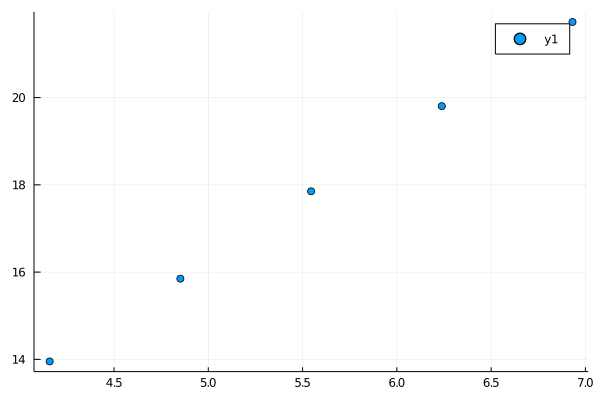

In [46]:
Meantimes = Queue{Any}()
while length(Trials) >= 1
    enqueue!(Meantimes, mean(dequeue!(Trials)).time)
end
Meantimes = collect(Meantimes)
Inputsize = 2 .^ collect(6: 10)
scatter(log.(Inputsize), log.(Meantimes))

In [21]:
methodswith(Queue)

[1] dequeue!(s::Queue) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:37
[2] enqueue!(s::Queue, x) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:27
[3] length(s::Queue) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:16
[4] ==(x::Queue, y::Queue) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:47
[5] empty!(s::Queue) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:39
[6] first(s::Queue) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:19
[7] isempty(s::Queue) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:15
[8] iterate(q::Queue, s...) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:43
[9] last(s::Queue) in DataStructures at C:\Users\victo\.julia\packages\DataStructures\5hvIb\src\queue.jl:20

1.153058410582255e6